In [ ]:
from scipy.optimize import least_squares, minimize, LinearConstraint, NonlinearConstraint, BFGS, SR1
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd
import yfinance as yf

In [ ]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    objective_value = np.linalg.norm(G) ** 2 + np.linalg.norm(S, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[X_len+G_len+S_len:]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-self.num_features:] = K_t

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = X1[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1), X2[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (self.D - X - G - S).flatten()
    
  def fit(self, D, bounds=None, retrain=False):
    if retrain:
      print("Using learned parameters")
      len_diff = D.shape[1] - self.X.shape[1]
      if len_diff == 0:
        X_initial_guess = self.X
      else:
        X_initial_guess = np.hstack((self.X, self.forecast(self.X, len_diff)))
      G_initial_guess, S_initial_guess, K_initial_guess = \
        np.hstack((self.G, np.zeros((D.shape[0], len_diff)))), np.hstack((self.S, np.zeros((D.shape[0], len_diff)))), self.K
    else:
      print("Learning from scratch")
      X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
        D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features, self.num_features*self.ar_order))

    min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
    self.min_val, self.max_val = min_val, max_val

    D = (D - min_val) / (max_val - min_val)
    X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
    G_initial_guess = G_initial_guess / (max_val - min_val)
    S_initial_guess = S_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    self.D = D
    self.idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(D.shape[1] - self.ar_order)).ravel()

    K = np.zeros((self.num_features * self.ar_order, self.num_features * self.ar_order))
    rows, cols = np.diag_indices(self.num_features * self.ar_order - self.num_features)
    K[rows, cols + self.num_features] = 1
    self.K = K

    hankel_constraint = NonlinearConstraint(self.hankel_constraint, 0, 0)
    D_constraint = NonlinearConstraint(self.D_constraint, 0, 0)

    # constraints = (
    #   {'type': 'eq', 'fun': self.hankel_constraint, 'args': (K, dims[0][0], dims[0][1], dims[1][1], dims[2][1], dims[3][0], idx_ravel)},
    #   {'type': 'eq', 'fun': self.D_constraint, 'args': (D, dims[0][0], dims[0][1], dims[1][0], dims[1][1], dims[2][0], dims[2][1])},
    # )
    constraints = [hankel_constraint, D_constraint]

    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints, options=options, jac='2-point', hess=BFGS())

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)

    X, G, S = X * (max_val - min_val) + min_val, G * (max_val - min_val), S * (max_val - min_val)
    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.num_features * self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [ ]:
# 1m26s, 192it - BFGS
# 2m2s, 226it - SR1
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=80
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=85
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = 220, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=200
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=205
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
data.shape

[*********************100%%**********************]  3 of 3 completed

Ticker            AAPL        GOOG        MSFT
Date                                          
2023-06-01  179.138626  124.370003  329.998535
2023-06-02  179.994095  125.230003  332.796600
2023-06-05  178.631348  126.629997  333.332489
2023-06-06  178.263306  127.910004  331.089966
2023-06-07  176.880646  122.940002  320.869965
...                ...         ...         ...
2024-05-24  189.979996  176.330002  430.160004
2024-05-28  189.990005  178.020004  430.320007
2024-05-29  190.289993  177.399994  429.170013
2024-05-30  191.289993  173.559998  414.670013
2024-05-31  192.250000  173.960007  415.130005

[252 rows x 3 columns]


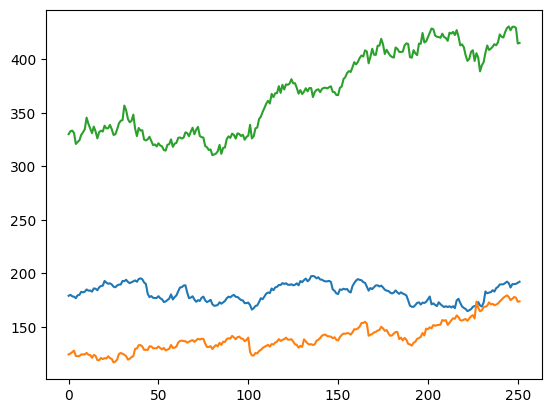

In [9]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
print(data)

D = data.to_numpy().T

plt.plot(D.T)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = D.shape[1], D.shape[0], 1, 10

train_data, test_data = D[:, :D.shape[1]-test_len], D[:, D.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=num_features, ar_order=order)
alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [20]:
class SimulatedTrades():
  def __init__(self, D, tickers, dates):
    """
    Instantiate the model with a dataset.
    """
    self.D, self.tickers, self.dates = D, tickers, dates

  def simulate(self, n, step=21, num_periods=12, k=1, test_len=21):
    """
    Get the first n datapoints of the dataset.
    Fit an order 'k' algorithm to the first 'n-test_len' datapoints and forecast 'test_len' datapoints.
    Retrain the algorithm by extending the dataset 'step' timesteps into the future.
    At each training, calculate and store P&Ls.
    """
    
    # set up random seed for reproducability
    np.random.seed(0)

    # define data variables
    D = self.D
    num_features = D.shape[0]

    # instantiate algorithm
    alg = Stage6Algorithm(num_features=num_features, ar_order=k)

    # get dates where forecasts will start
    dates = []
    for i in range(num_periods):
      idx = (n + step * i) - test_len
      start_date = self.dates[idx]
      dates.append(start_date)

    # set up P&L dataframe
    index = pd.MultiIndex.from_product([dates, self.tickers], names=['Start Date', 'Ticker'])
    df = pd.DataFrame(index=index, columns=['Buy', 'Sell', 'L/S', 'Gain', 'Percent P&L'])

    # loop through all the periods and forecast
    retrain = False
    for i in range(num_periods):
      subset = D[:, :(n + step * i)]
      num_elements = subset.shape[1]

      # train-test split
      train_data, test_data = subset[:, :subset.shape[1]-test_len], subset[:, subset.shape[1]-test_len:]

      # train the algo
      alg.fit(train_data, retrain=retrain)
      retrain = True

      # forecast
      fitted = alg.X
      forecasted = alg.forecast(fitted, test_len)
      
      # plot results
      plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
      plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
      plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
      plt.legend()
      plt.show()

      # get the directions of price movements
      directions = forecasted[:, -1] - fitted[:, -1]
      for j in range(D.shape[0]):
        ticker = self.tickers[j]
        date = self.dates[n+step*i]
        
        # for each stock, check the direction, buy or sell, calculate P&L
        direction = directions[i]
        ls = None
        if direction >= 0:
          # buy
          ls = 'L'
        else:
          # sell
          ls = 'S'
        
        df.loc[(date, ticker), ['Buy', 'Sell', 'L/S']] = [test_data[i, 0], test_data[i, -1], ls]
      
      print(df)
      self.pnl = df
      print("------------------------------------------------------------------------------")

[*********************100%%**********************]  3 of 3 completed

Ticker            AAPL        GOOG        MSFT
Date                                          
2022-06-01  147.046356  114.137001  267.717682
2022-06-02  149.518402  117.746002  269.840393
2022-06-03  143.753616  114.564003  265.359070
2022-06-06  144.505127  117.010498  264.111053
2022-06-07  147.046356  117.229500  267.796295
...                ...         ...         ...
2024-05-24  189.979996  176.330002  430.160004
2024-05-28  189.990005  178.020004  430.320007
2024-05-29  190.289993  177.399994  429.170013
2024-05-30  191.289993  173.559998  414.670013
2024-05-31  192.250000  173.960007  415.130005

[503 rows x 3 columns]
['2022-06-01T00:00:00.000000000' '2022-06-02T00:00:00.000000000'
 '2022-06-03T00:00:00.000000000' '2022-06-06T00:00:00.000000000'
 '2022-06-07T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-09T00:00:00.000000000' '2022-06-10T00:00:00.000000000'
 '2022-06-13T00:00:00.000000000' '2022-06-14T00:00:00.000000000'
 '2022-06-15T00:00:00.000000000' '2022-0

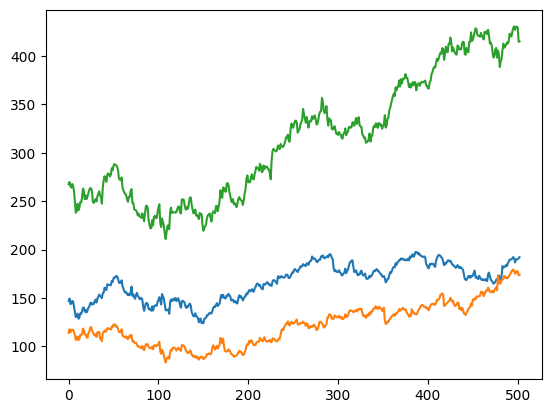

In [21]:
data = yf.download("MSFT AAPL GOOG", period="2y")['Adj Close']
print(data)
dates = data.index.values
print(dates)
tickers = data.columns.values
print(tickers)
D = data.to_numpy().T
print(D)
plt.plot(D.T)

In [23]:
trader = SimulatedTrades(D=D, tickers=tickers, dates=dates)

step, k, num_periods, test_len = 21, 1, 2, 21
trader.simulate(n=D.shape[1] // 2, step=step, num_periods=num_periods, k=k, test_len=test_len)

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


KeyboardInterrupt: 

In [ ]:
for i in range(train_data.shape[0]):
  plt.plot(range(train_data.shape[1]), train_data[i].T, label="True Train")
  plt.plot(range(train_data.shape[1]), fitted[i].T, label="Fitted")
  plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[i].T, label="True Test")
  plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[i].T, label="Forecast")
  plt.show()

In [ ]:
k = 10

min_val, max_val = train_data.min(axis=1).reshape(-1, 1), train_data.max(axis=1).reshape(-1, 1)
X_t = (X_t - min_val) / (max_val - min_val)

X_t = fitted[:, -1]

# Eigenvalue decomposition of A
eigenvalues, eigenvectors = np.linalg.eig(alg.K)
V = eigenvectors
V_inv = np.linalg.inv(V)
Lambda = np.diag(eigenvalues)

# Transform the system to the eigenvector basis
Y_t = np.matmul(V_inv, X_t)

forecasts = np.zeros((X_t.shape[0], k))
for step in range(k):
  # Forecast in the transformed basis
  Lambda_k = np.linalg.matrix_power(Lambda, step)

  Y_t_k = np.matmul(Lambda_k, Y_t) #+ np.dot(sum_term, np.dot(V_inv, c))

  # Transform back to the original basis
  X_t_k = np.matmul(V, Y_t_k)

  forecasts[:, step] = X_t_k

plt.plot(forecasts.T)

In [ ]:
for i in range(train_data.shape[0]):
  plt.plot(range(train_data.shape[1]), train_data[i].T, label="True Train")
  plt.plot(range(train_data.shape[1]), fitted[i].T, label="Fitted")
  plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[i].T, label="True Test")
  plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasts[i].T, label="Forecast")
  plt.show()